# Pre-Requisites
1.

Visit the link [https://drive.google.com/file/d/1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1/view?usp=sharing]


Go to drive.google.com

Under 'Shared with me', find the file named **Image_Captioning_Dataset.zip**

Right click -> Add Shortcut to Drive

Select 'My Drive' 

Click 'Add Shortcut'

---

2.
Visit the link [https://drive.google.com/file/d/1QG2_tAFLroc4ATSOLRiEAwYTYTsL_xVc/view?usp=sharing]

Go to drive.google.com

Under 'Shared with me', find the file named **set_3.pkl**

Right click -> Add Shortcut to Drive

Select 'My Drive' 

Click 'Add Shortcut'



In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pickle
from google.colab import drive
import re
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from itertools import islice
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import os

from operator import itemgetter
import matplotlib.pyplot as plt
import pandas as pd

from keras.preprocessing.image import load_img
from IPython.display import Image, display
import math
from textwrap import wrap

import numpy as np
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, GRU, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from pickle import dump
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
drive_path = '/content/gdrive'
drive.mount(drive_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
root_path = '{}/MyDrive'.format(drive_path)

pickle_path = '{}/set_3.pkl'.format(root_path)

dataset_zip_path = '{}/Image_captioning_Dataset.zip'.format(root_path)
dataset_path = '{}/Flicker8k_Dataset'.format(root_path)

glove_zip_name = 'glove.6B.zip'
glove_zip_path = '{}/{}'.format(root_path, glove_zip_name)
glove_dataset_file = '{}/glove.6B.200d.txt'.format(root_path)

In [4]:
# download and copy/move glove dataset to drive
if not os.path.exists(glove_zip_path):
  print("downloading glove dataset, please wait for some time...")
  !wget 'https://nlp.stanford.edu/data/glove.6B.zip'

  print("uploading glove dataset to drive, this may take a few minutes...")
  !mv {'./' + glove_zip_name}  {glove_zip_path}
  with zipfile.ZipFile(glove_zip_path,"r") as zip_ref:
    zip_ref.extractall(os.path.dirname(glove_zip_path))


In [5]:
# extract the dataset
if not os.path.exists(dataset_path):
  print("extracting image_captioning dataset, this may take a couple of minutes...")
  with zipfile.ZipFile(dataset_zip_path,"r") as zip_ref:
      zip_ref.extractall(os.path.dirname(dataset_zip_path))
else:
  print("dataset extracted already!")

dataset extracted already!


In [6]:
# read the pickle dataset
objects = []
with open(pickle_path, "rb") as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
print(len(objects))
objects[0][:10]

1


['3033668641_5905f73990.jpg#0\tA man in a white helmet cling to a sheer rock face',
 '2608289957_044849f73e.jpg#0\tA baby sit on a tire and hold a toy .',
 '2723477522_d89f5ac62b.jpg#4\ttwo dog play in the grass .',
 '3453019315_cfd5c10dae.jpg#2\tA man do a bike trick on a dirt path .',
 '3524975665_7bec41578b.jpg#1\tA woman in a yellow jacket and brown hat stand on a path by a lake .',
 '3461041826_0e24cdf597.jpg#2\tA black and white dog be splash in a stream .',
 '414568315_5adcfc23c0.jpg#4\tA child be use chopstick on overturned kitchen item .',
 '2657484284_daa07a3a1b.jpg#0\tA kayak on a river be pass by a wire bridge that join both bank .',
 '2860667542_95abec3380.jpg#2\tA white water bird take flight from a lake .',
 '2222498879_9e82a100ab.jpg#3\tA tan and black dog walk happy through a field .']

In [30]:
# convert to required format, remove punctuations, lowercase the captions.

captions_dict = defaultdict(list)
tokenizer = RegexpTokenizer(r'\w+')

for record in objects[0]:
  (name, caption_num, caption) = re.split(r'#|\t', record, maxsplit=2)

  # do not add it to captions_dict (or training/testing sets if we don't have a file for it.)
  if not os.path.exists(os.path.join(dataset_path, name)):
    continue
  
  # remove stopwords, convert to lowercase, remove punctuations.
  caption_words = tokenizer.tokenize(caption.lower())
  captions_dict[name].append(' '.join(caption_words))

dict(islice(captions_dict.items(), 5))


{'2608289957_044849f73e.jpg': ['a baby sit on a tire and hold a toy',
  'boy in pajama with red and yellow toy seat on tire near plant',
  'a little kid with a red toy be sit on a tire',
  'child hold plastic car sit on a tire'],
 '2723477522_d89f5ac62b.jpg': ['two dog play in the grass',
  'a large brown dog be chase after a little brown dog',
  'a big dog chase a little dog on the grass',
  'two brown dog run through the grass together'],
 '3033668641_5905f73990.jpg': ['a man in a white helmet cling to a sheer rock face',
  'a man with all his equipment rock climb',
  'a rock climber wear a white helmet'],
 '3453019315_cfd5c10dae.jpg': ['a man do a bike trick on a dirt path',
  'man perform a trick on a bicycle outside',
  'a helmeted male airborne on a bike on a dirt road'],
 '3524975665_7bec41578b.jpg': ['a woman in a yellow jacket and brown hat stand on a path by a lake',
  'a young woman wait under a sculpture in a park',
  'a woman in a yellow coat be stand on a sidewalk']}

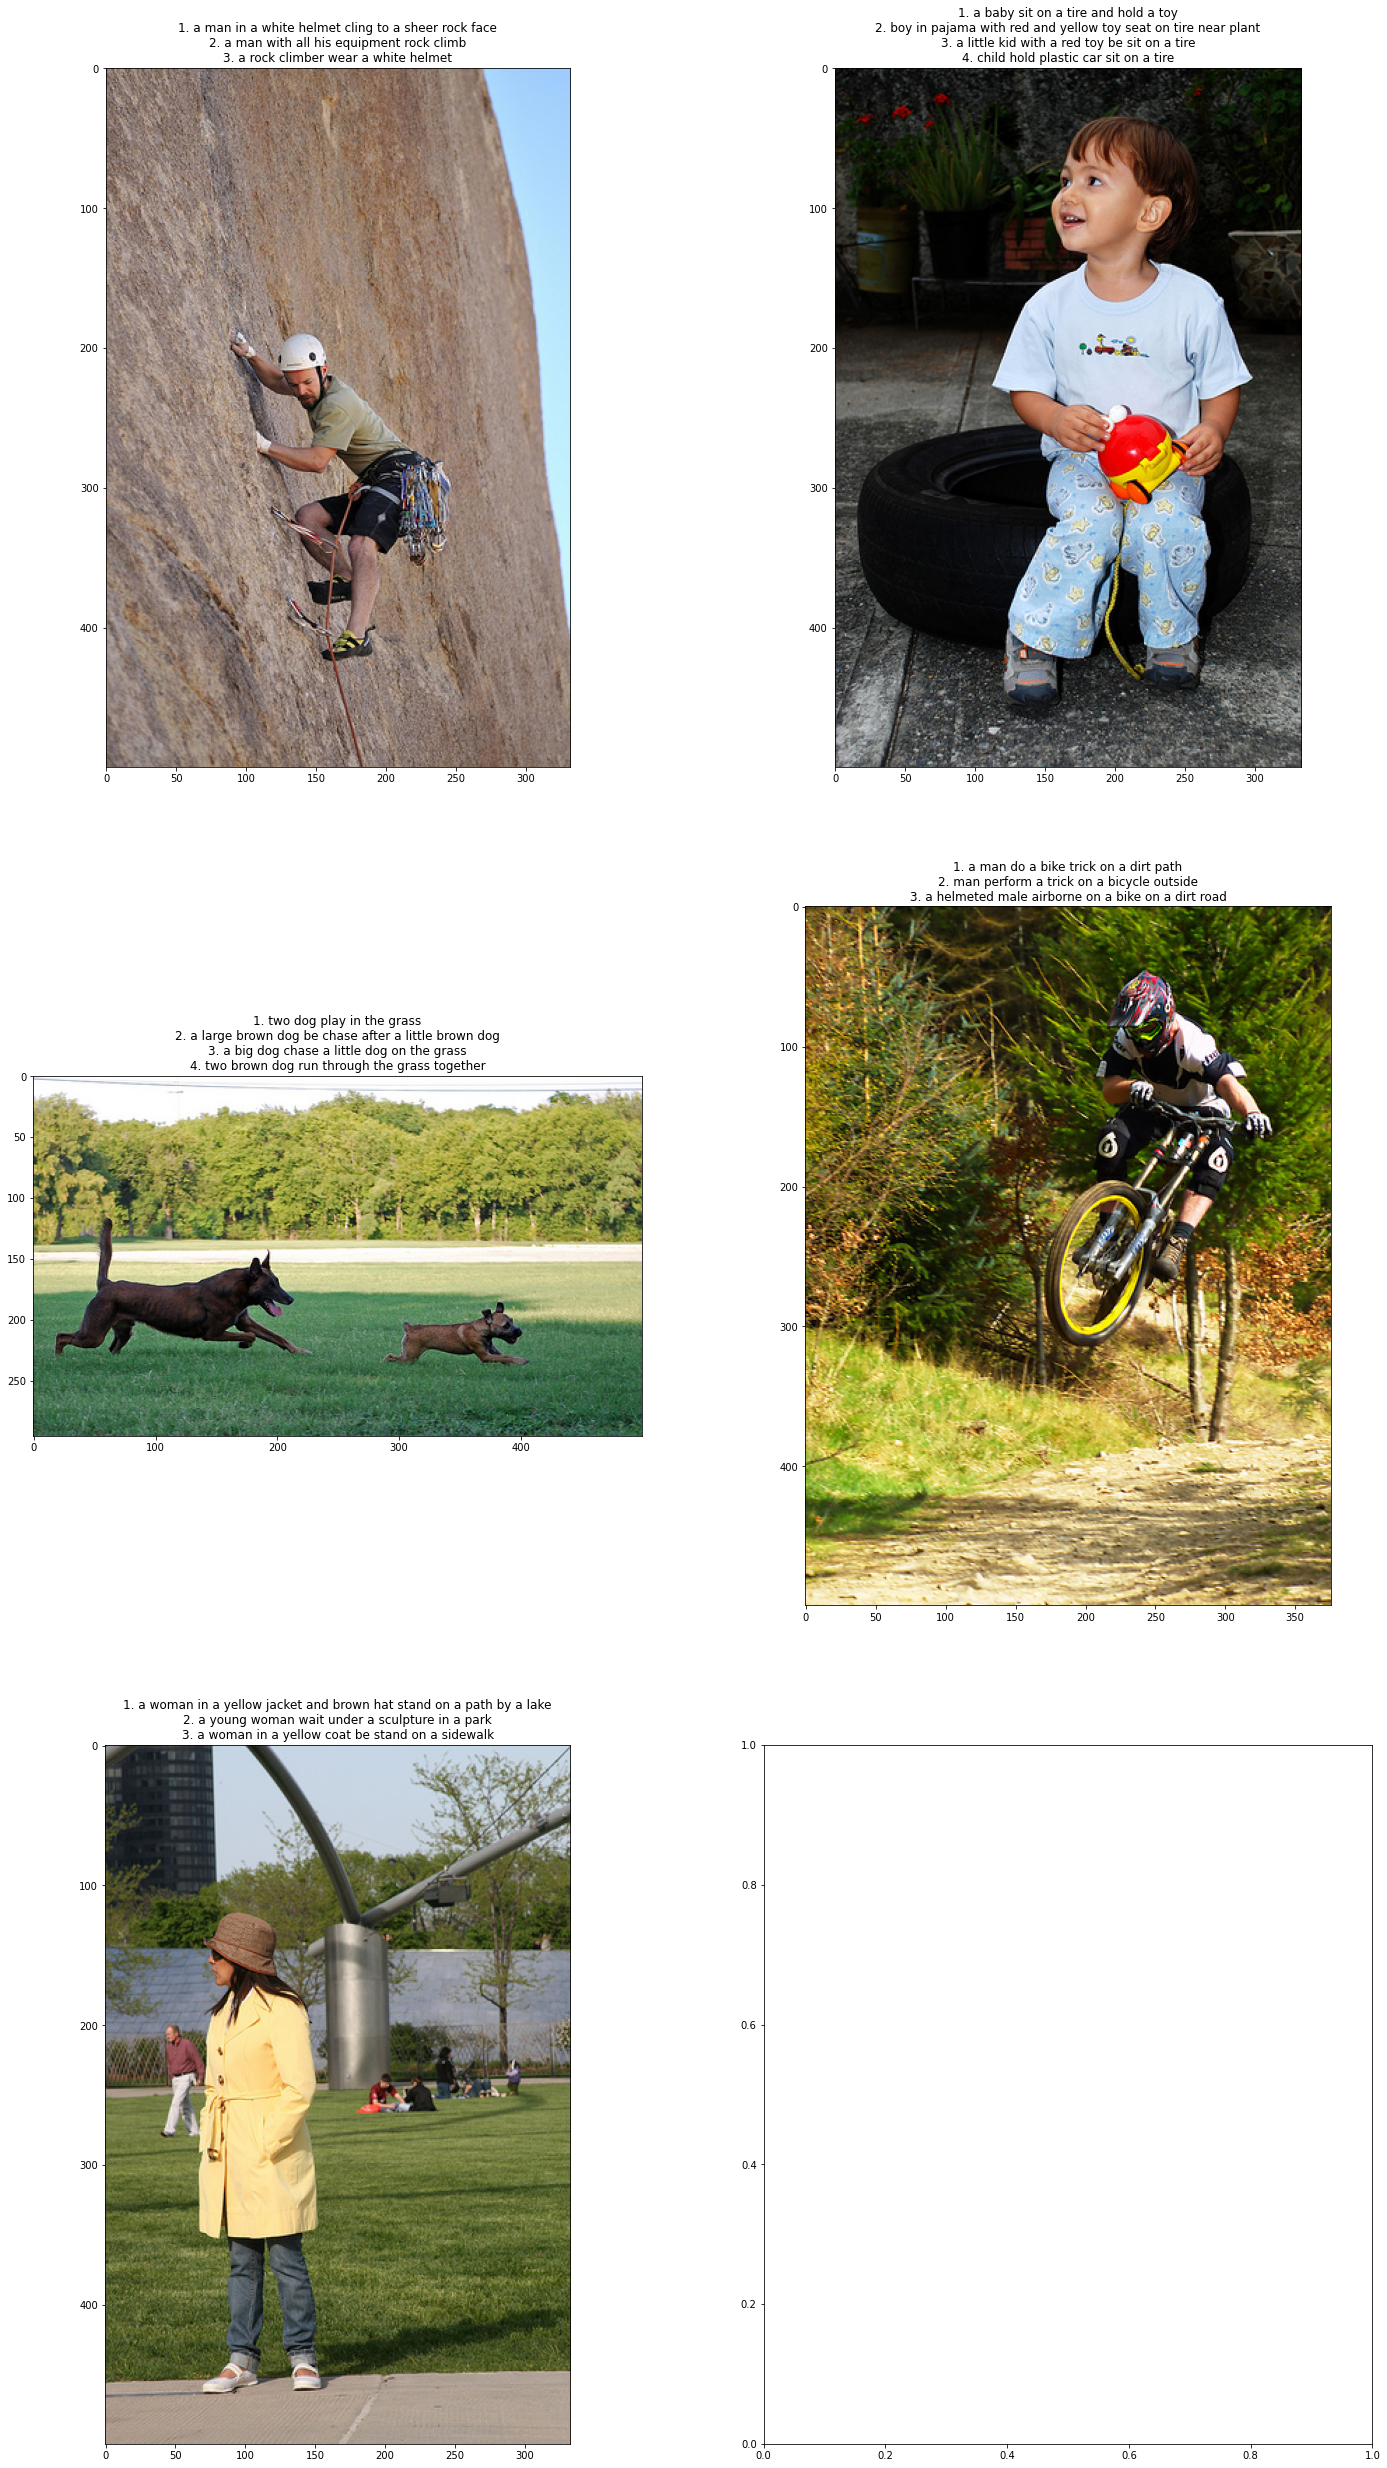

In [8]:
# display N sample images and their captions.


def display_images(dataset_path, filenames, captions_dict, title=True):

  N = len(filenames)
  ncols = 2   # number of columns in the grid

  # create a grid.
  fig, axes = plt.subplots(nrows=math.ceil(N/ncols), ncols=ncols, figsize=(24,24), squeeze=False)

  # adjust grid spacing to accomodate multiple captions.
  fig.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)


  count = 0
  for filename in filenames:
    (i, j) = (count // ncols, count % ncols)    # grid i, j coordinates
    image = load_img(os.path.join(dataset_path, filename))
    axes[i, j].imshow(image)

    # number the title, wrap long titles (to default 70 char width)
    if title:
      title = "\n".join(["{}. {}".format(i+1, "\n".join(wrap(v))) for i, v in enumerate(captions_dict[filename])])
      axes[i, j].title.set_text(title)

    count += 1
    if count >= N:
      break


display_images(dataset_path, list(captions_dict.keys())[:5], captions_dict)

In [31]:
# split captions data in training/test sets

train_ratio = 0.9

image_names = [x for x in captions_dict.keys()]

# NOTE: 
# with shuffle = False, The code shall extract image features on the first run, and
# save it to disk for training and testing datasets, subsequent runs shall re-use the same image feature dump.
# 
# shuffle=True will re-extract training/test image features every time and will NOT
# save it do disk.
shuffle = False
if shuffle:
  np.random.shuffle(image_names)

train_size = int(len(image_names) * train_ratio)

train_data = dict({k: captions_dict[k] for k in image_names[:train_size]})
test_data = dict({k: captions_dict[k] for k in image_names[train_size:]})

print("sample captions from training dataset\n------------------")
print(dict(islice(train_data.items(), 5)), "\n\n")
print("sample captions from testing dataset\n------------------")
print(dict(islice(test_data.items(), 5)), "\n\n")
'size - training dataset: {}, testing dataset: {}'.format(len(train_data), len(test_data))

sample captions from training dataset
------------------
{'3033668641_5905f73990.jpg': ['a man in a white helmet cling to a sheer rock face', 'a man with all his equipment rock climb', 'a rock climber wear a white helmet'], '2608289957_044849f73e.jpg': ['a baby sit on a tire and hold a toy', 'boy in pajama with red and yellow toy seat on tire near plant', 'a little kid with a red toy be sit on a tire', 'child hold plastic car sit on a tire'], '2723477522_d89f5ac62b.jpg': ['two dog play in the grass', 'a large brown dog be chase after a little brown dog', 'a big dog chase a little dog on the grass', 'two brown dog run through the grass together'], '3453019315_cfd5c10dae.jpg': ['a man do a bike trick on a dirt path', 'man perform a trick on a bicycle outside', 'a helmeted male airborne on a bike on a dirt road'], '3524975665_7bec41578b.jpg': ['a woman in a yellow jacket and brown hat stand on a path by a lake', 'a young woman wait under a sculpture in a park', 'a woman in a yellow coat b

'size - training dataset: 7214, testing dataset: 802'

In [32]:
# update training and test data captions with BOS/EOS markers
for key, captions in train_data.items():
  new_captions = ['startseq {} endseq'.format(caption) for caption in captions]
  train_data[key] = new_captions

for key, captions in test_data.items():
  new_captions = ['startseq {} endseq'.format(caption) for caption in captions]
  test_data[key] = new_captions

print("sample captions from training dataset\n------------------")
print(dict(islice(train_data.items(), 5)), "\n\n")
print("sample captions from testing dataset\n------------------")
print(dict(islice(test_data.items(), 5)), "\n\n")
'size - training dataset: {}, testing dataset: {}'.format(len(train_data), len(test_data))

sample captions from training dataset
------------------
{'3033668641_5905f73990.jpg': ['startseq a man in a white helmet cling to a sheer rock face endseq', 'startseq a man with all his equipment rock climb endseq', 'startseq a rock climber wear a white helmet endseq'], '2608289957_044849f73e.jpg': ['startseq a baby sit on a tire and hold a toy endseq', 'startseq boy in pajama with red and yellow toy seat on tire near plant endseq', 'startseq a little kid with a red toy be sit on a tire endseq', 'startseq child hold plastic car sit on a tire endseq'], '2723477522_d89f5ac62b.jpg': ['startseq two dog play in the grass endseq', 'startseq a large brown dog be chase after a little brown dog endseq', 'startseq a big dog chase a little dog on the grass endseq', 'startseq two brown dog run through the grass together endseq'], '3453019315_cfd5c10dae.jpg': ['startseq a man do a bike trick on a dirt path endseq', 'startseq man perform a trick on a bicycle outside endseq', 'startseq a helmeted ma

'size - training dataset: 7214, testing dataset: 802'

In [33]:
# create a word count dictionary.

vocabulary = set()
word_count = defaultdict(lambda: 0)
for captions in train_data.values():
  for caption in captions:
    for word in str.split(caption, ' '):
      vocabulary.add(word)
      if word not in ['startseq', 'endseq']:
        word_count[word] += 1

# sort the word count dict by values.
word_count = dict(sorted(word_count.items(), key = itemgetter(1), reverse = True))

# total vocab size
print(len(vocabulary))

5142


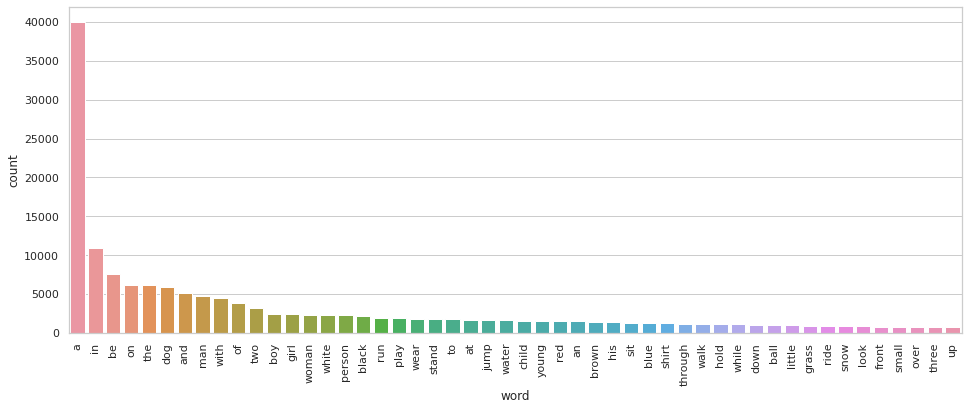

In [34]:
# plot top 50 words from word_count dict.
plt.figure(figsize=(16,6))
plt.xticks(rotation='vertical')

df = pd.DataFrame(word_count.items(), columns=['word', 'count'])
sns.set(style="whitegrid")
sns.barplot(x='word', y='count', data=df[:50])



count    24995.000000
mean        10.775155
std          3.773125
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         33.000000
Name: caption_size, dtype: float64

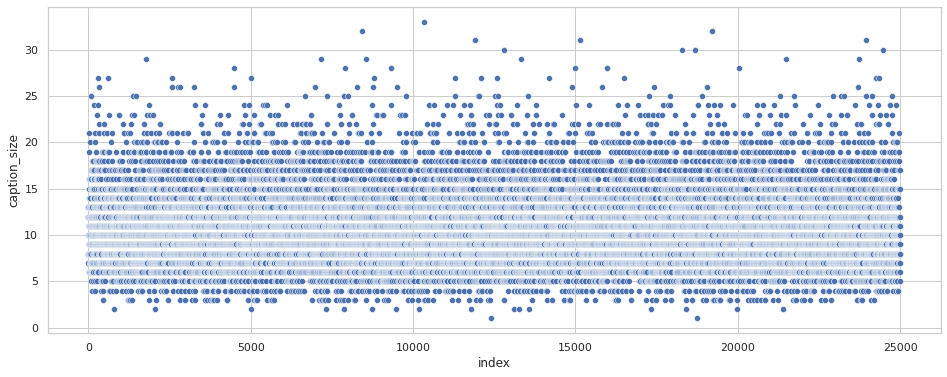

In [35]:
# caption words (min, max, avg.)

caption_sizes = {}
i=0
for captions in captions_dict.values():
  for caption in captions:
    caption_sizes[i] = len(str.split(caption, ' '))
    i += 1

df1 = pd.DataFrame(caption_sizes.items(), columns=['index', 'caption_size'])

plt.figure(figsize=(16,6))

sns.set(style="whitegrid")
sns.scatterplot(x='index', y='caption_size', data=df1)
df1['caption_size'].describe()



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

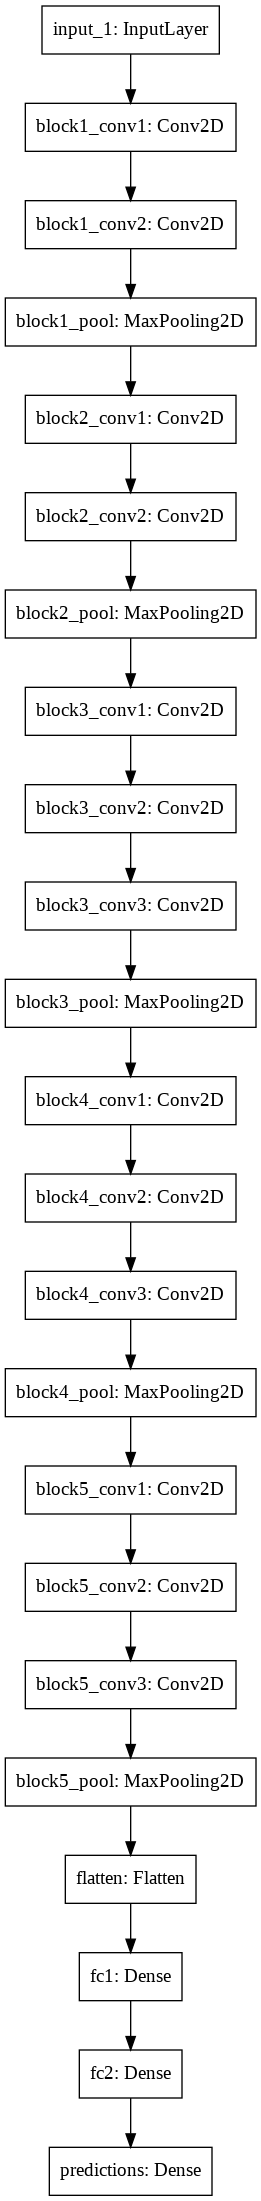

In [14]:
# use the VGG16 pretrained model to extract features from images.
model = VGG16(weights='imagenet')
print(model.summary())
plot_model(model, to_file='{}/vgg.png'.format(root_path))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

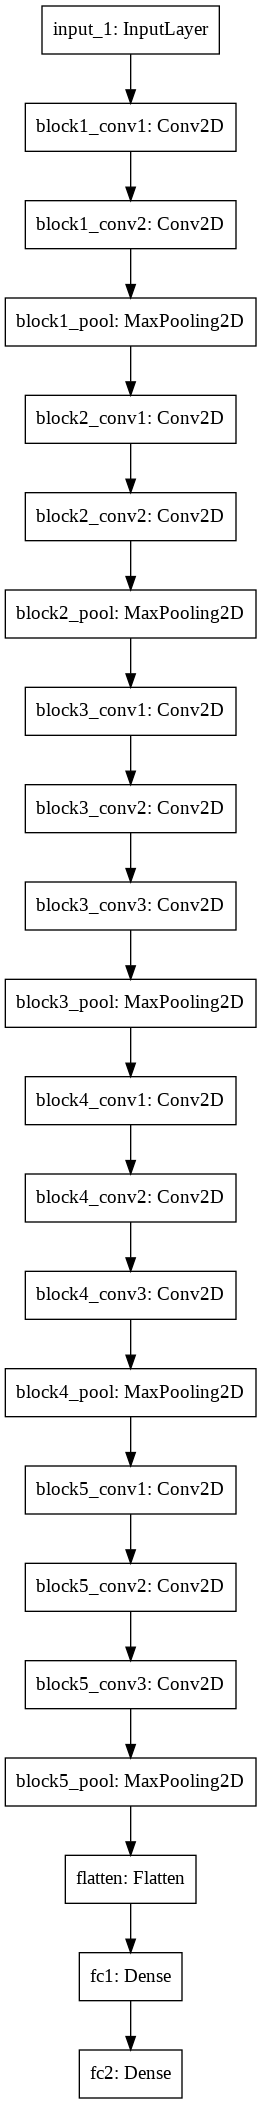

In [15]:
# recreate model removing last prediction layer
model1 = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model1.summary())
plot_model(model1, to_file='{}/vgg-1.png'.format(root_path))

---

The model above takes images as **224 x 224 x 3** size.

---



In [16]:
from numpy import expand_dims

# use above model to extract features from images.
def extract_image_features(model, data, dataset_path):
  image_features = dict()
  for filename in data.keys():
    
    filepath = os.path.join(dataset_path, filename)
    if not os.path.exists(filepath):
      continue

    image = load_img(filepath, target_size=(224, 224))
    
    # reshape the image
    image = img_to_array(image)
    image = expand_dims(image, axis=0)

    # preprocess
    image = preprocess_input(image)
    
    # extract features
    image_features[filename] = model1.predict(image, verbose=0)

  return image_features


train_data_dump_path = '{}/image_features_train-set.pkl'.format(root_path)
test_data_dump_path = '{}/image_features_test-set.pkl'.format(root_path)

if shuffle or not os.path.exists(train_data_dump_path):
  print("extracting image features from training data.. please wait for 5-10 minutes.")
  image_features_train = extract_image_features(model, train_data, dataset_path)

  # No point in saving shuffled image features to disk, as next suffle won't have
  # the same set of images in training or test dataset.
  if not shuffle:
    with open(train_data_dump_path, "wb") as fh:
      dump(image_features_train, fh)

if shuffle or not os.path.exists(test_data_dump_path):
  print("extracting image features from test data.. please wait for 2-3 minutes.")

  image_features_test = extract_image_features(model, test_data, dataset_path)
  # No point in saving shuffled image features to disk, as next suffle won't have
  # the same set of images in training or test dataset.
  if not shuffle:
    with open(test_data_dump_path, "wb") as fh:
      dump(image_features_test, fh)


In [17]:
# load image features from test dump file, display samples.

print("loading training image features from pickle file")
with open(test_data_dump_path, "rb") as fh:
  image_features_test = pickle.load(fh)

print('feature set size: {}'.format(len(image_features_test)))

# print 5 items
dict(islice(image_features_test.items(), 5))


loading training image features from pickle file
feature set size: 802


{'1499495021_d295ce577c.jpg': array([[0.42266178, 0.        , 0.06778109, ..., 0.        , 4.343462  ,
         0.886196  ]], dtype=float32),
 '2167644298_100ca79f54.jpg': array([[1.9898707, 1.854141 , 0.       , ..., 0.       , 1.9532623,
         2.3647237]], dtype=float32),
 '3228517564_74b00a923b.jpg': array([[0.        , 0.        , 0.        , ..., 0.        , 0.06291944,
         2.6010358 ]], dtype=float32),
 '3259992638_0612a40288.jpg': array([[0.       , 0.       , 0.       , ..., 0.       , 1.8456643,
         0.5030978]], dtype=float32),
 '3471841031_a949645ba8.jpg': array([[1.4077761, 1.5905311, 1.8254167, ..., 0.       , 1.9458985,
         0.       ]], dtype=float32)}

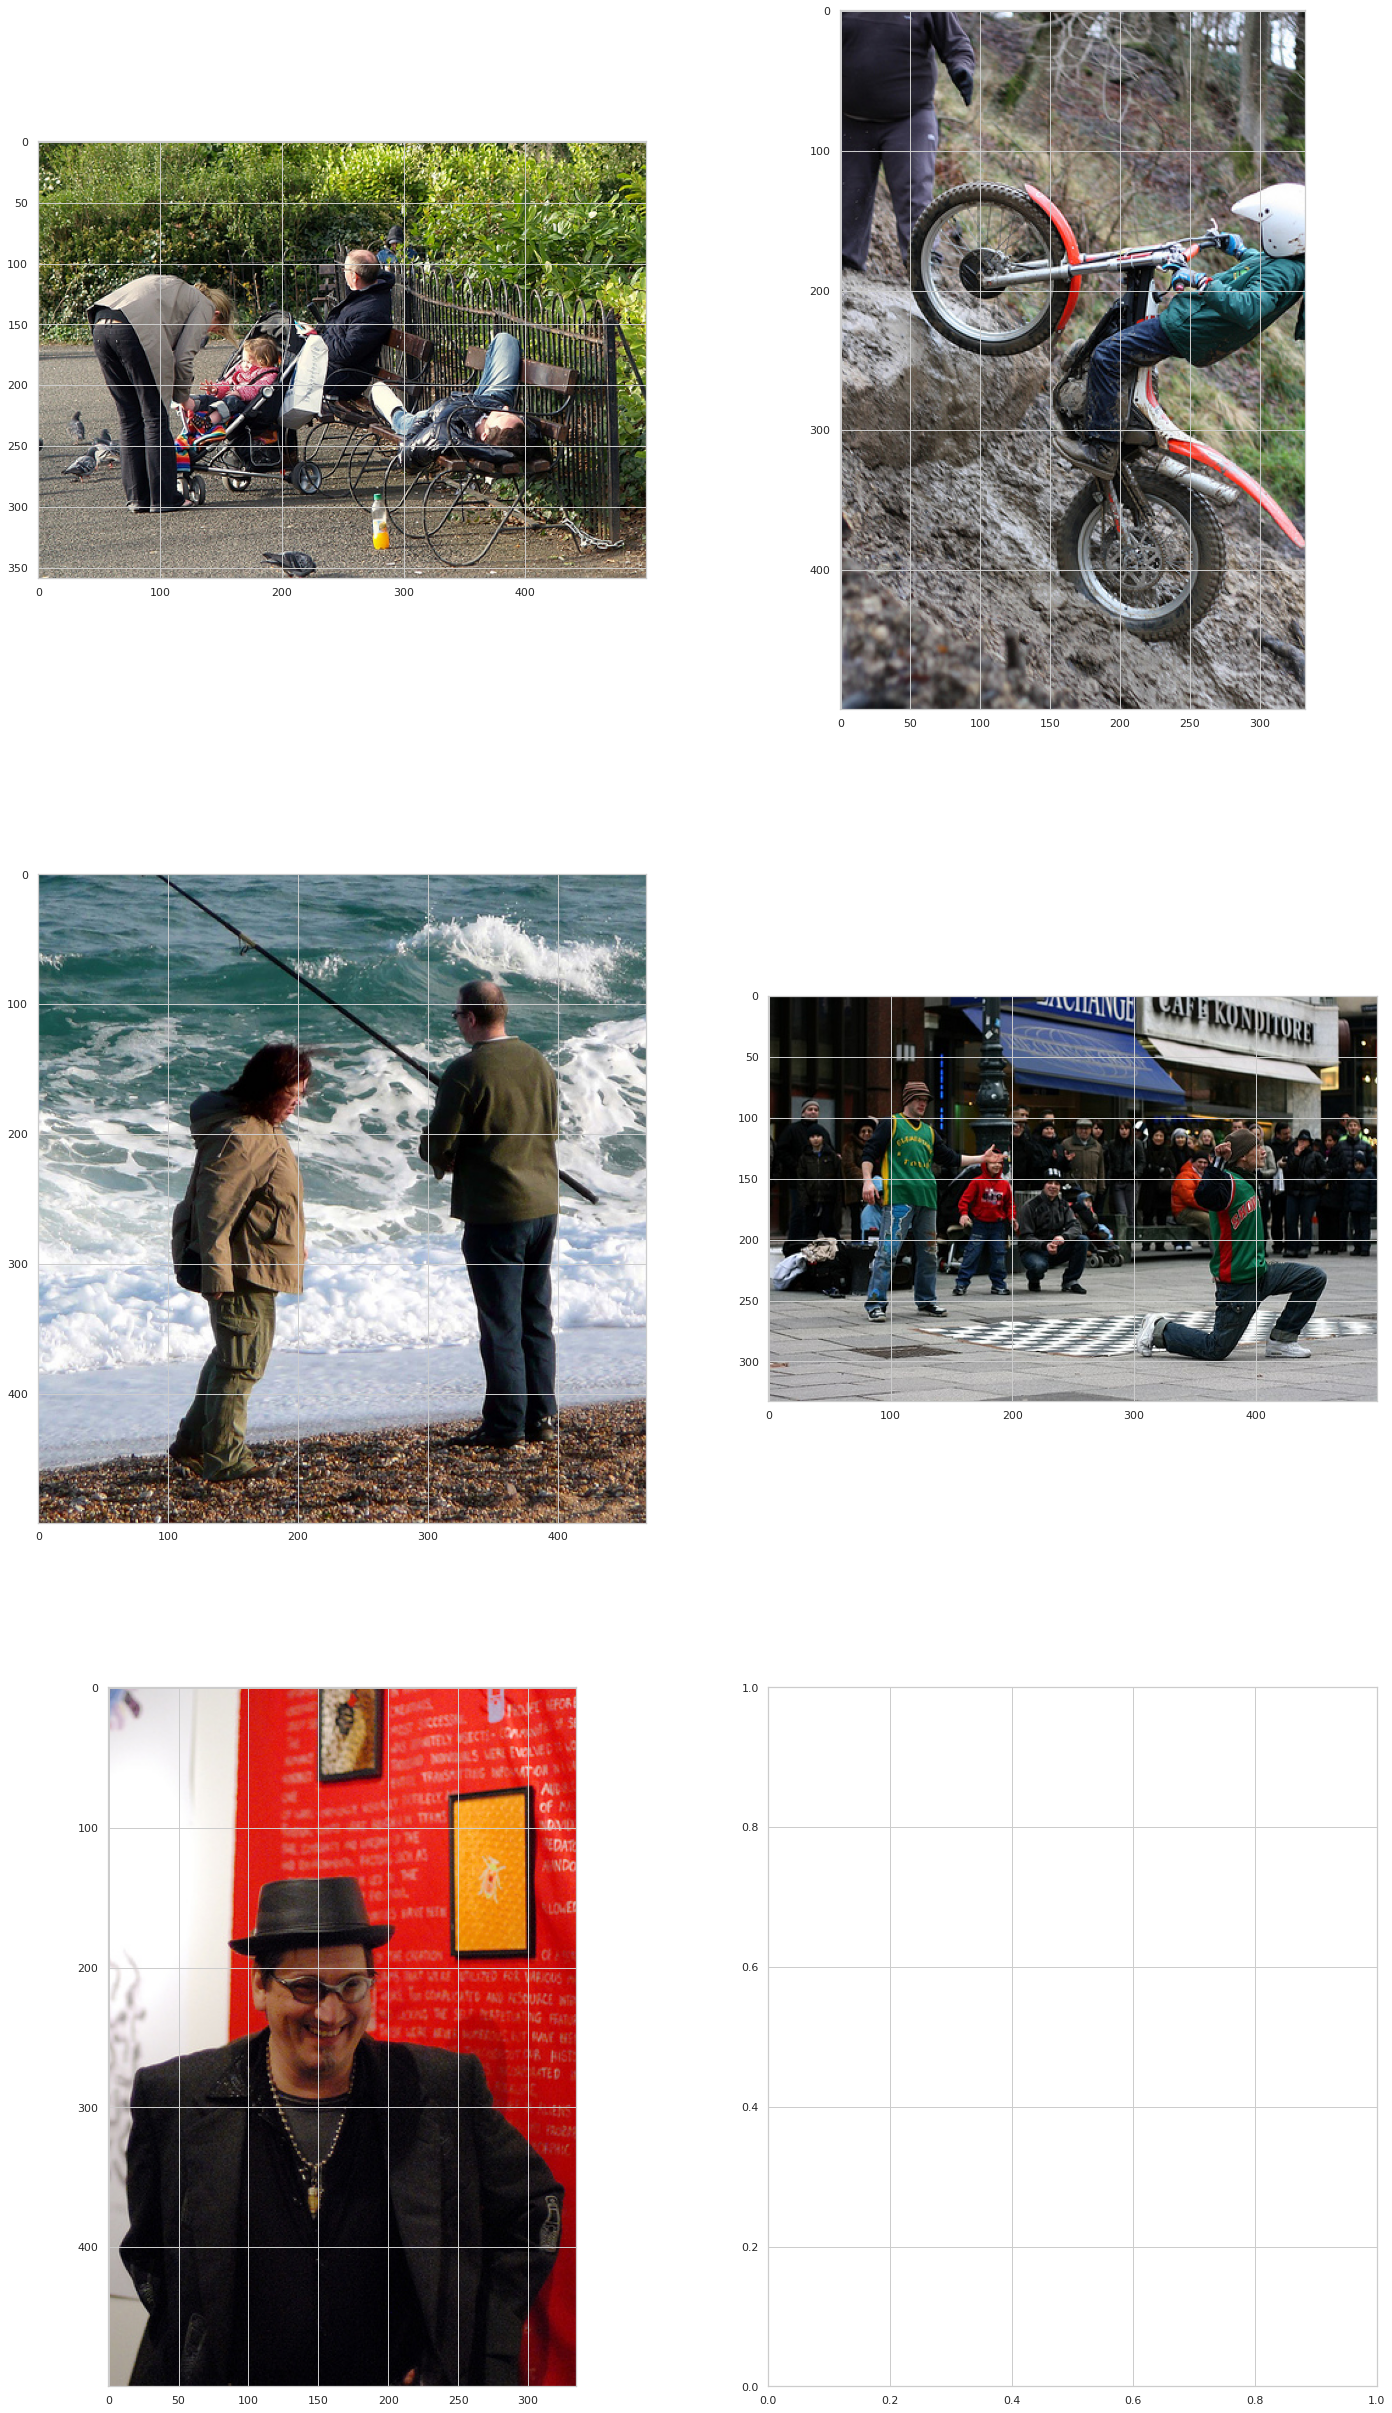

In [18]:
# display some test data, before generating captions for it.

display_images(dataset_path, list(test_data.keys())[:5], test_data, title=False)

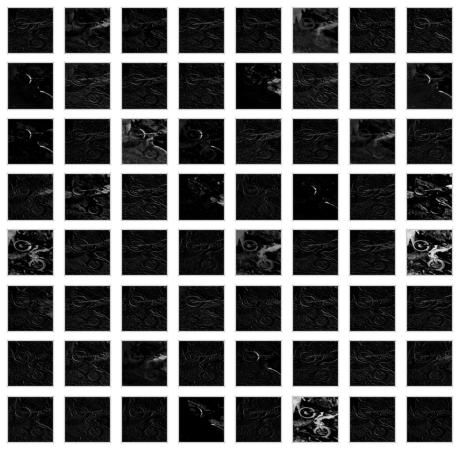

In [19]:
# also display extaracted features for the above images.
def display_features(filename, layer=1):

  features = 64
  ncols = 8   # number of columns in the grid
  nrows = features//ncols

  layer_op = Model(inputs=model.inputs, outputs=model.layers[layer].output)

  # create a grid.
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,8), squeeze=False)

  image = load_img(os.path.join(dataset_path, filename), target_size=(224, 224))
  image = img_to_array(image)
  image = expand_dims(image, axis=0)
  image = preprocess_input(image)

  feature_map = layer_op.predict(image)
  for fmap in feature_map:
    count = 0
    for r in range(nrows):
      for c in range(ncols):
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])
        axes[r, c].imshow(fmap[ :, :, count], cmap='gray')
        count += 1


# displaying features (produced at layer 1) from the biker photo above (index 1).
photo_index = 1
display_features(list(test_data.keys())[photo_index], layer=1)

---

Let's generate captions for the images above.

---

In [20]:
# interpret the output of prediction layer.
from keras.applications.vgg16 import decode_predictions

img_name = list(test_data.keys())[photo_index]
image = load_img(os.path.join(dataset_path, img_name), target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
yhat = model.predict(image)
label = decode_predictions(yhat)
print(label)



[[('n03792782', 'mountain_bike', 0.7762137), ('n04509417', 'unicycle', 0.11262635), ('n03127747', 'crash_helmet', 0.09502839), ('n09193705', 'alp', 0.0038581863), ('n01735189', 'garter_snake', 0.0033152862)]]


In [21]:
# create a word count dictionary.
word_count = defaultdict(lambda: 0)
for word in caption_words:
  word_count[word] += 1

vocab_len = len(vocabulary) + 1   # add 1 for padding.

max_caption_len = df1['caption_size'].max()
"vocabulary length: {}, max caption length: {}".format(vocab_len, max_caption_len)

'vocabulary length: 5143, max caption length: 33'

In [22]:
# using tokenizer for word <-> index mappings.
from keras.preprocessing.text import Tokenizer as KerasTokenizer
tokenizer = KerasTokenizer(num_words=vocab_len)
tokenizer.fit_on_texts(vocabulary)

print(tokenizer.word_index)
print(tokenizer.index_word)

{'telephot': 1, 'tortoise': 2, 'cloak': 3, 'brige': 4, 'east': 5, 'caution': 6, 'miscellaneous': 7, 'oar': 8, 'float': 9, 'fashioned': 10, 'walk': 11, 'mitten': 12, 'bumpy': 13, 'barettes': 14, 'strainer': 15, 'angrily': 16, 'otherwise': 17, 'para': 18, 'road': 19, 'concert': 20, 'monk': 21, 'footbride': 22, 'contestant': 23, 'hound': 24, 'zig': 25, 'picket': 26, 'wetland': 27, 'canned': 28, 'hardhat': 29, 'french': 30, 'wait': 31, 'grab': 32, 'refugee': 33, 'country': 34, 'tell': 35, 'blouse': 36, 'tomato': 37, '17': 38, 'hp': 39, 'gathering': 40, 'gush': 41, 'multicolored': 42, 'toss': 43, 'wife': 44, 'snowbank': 45, 'library': 46, 'trace': 47, 'lawn': 48, 'tow': 49, 'afro': 50, 'mostly': 51, 'clowds': 52, 'buddy': 53, 'name': 54, 'headed': 55, 'smilling': 56, 'life': 57, 'gym': 58, 'nap': 59, 'fuchsia': 60, 'car': 61, 'stock': 62, 'pf': 63, 'tubular': 64, 'brwon': 65, 'secret': 66, 'scantily': 67, 'remove': 68, 'house': 69, 'sequoia': 70, 'jug': 71, 'lump': 72, 'begin': 73, 'masses'

In [23]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
with open(glove_dataset_file, "r", encoding="utf-8") as fh:
  for line in fh:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

embedding_dim = 200
# Get 200-dim dense vector for each of the words in out vocabulary
embedding_matrix = np.zeros((vocab_len, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 200)      1028600     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_2[0][0]                    
____________________________________________________________________________________________

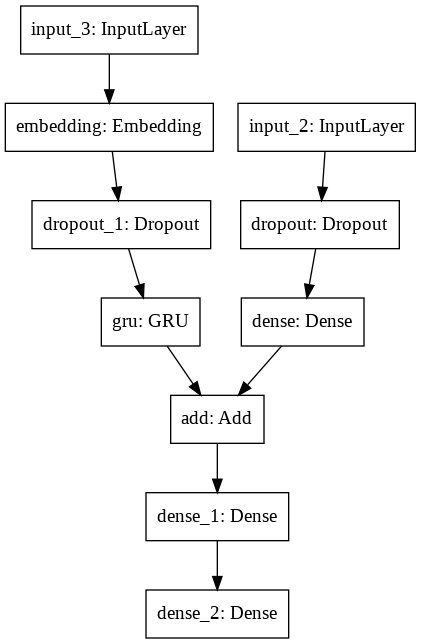

In [24]:
from tensorflow.keras import regularizers

# image feature extractor model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_caption_len,))
se1 = Embedding(vocab_len, output_dim=200,  mask_zero=True)(inputs2)
se2 = Dropout(0.3)(se1)
se3 = GRU(256, kernel_regularizer=regularizers.l2(0.01))(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

# merge the two input models
model2 = Model(inputs=[inputs1, inputs2], outputs=outputs)
model2.layers[2].set_weights([embedding_matrix])
model2.layers[2].trainable = False
model2.compile(loss='categorical_crossentropy', optimizer='adam')
model2.summary()
plot_model(model2)

In [29]:
def data_gen(captions, features, word_index, max_caption_len, vocab_len, num_photos_per_batch):
  X1, X2, y = list(), list(), list()
  # word_index = tokenizer.word_index
  n=0
  # loop for ever over images
  while 1:
    for key, desc_list in captions.items():
      n+=1
      # retrieve the photo feature
      photo = features[key]
      for desc in desc_list:
        # encode the sequence
        seq = [word_index[word] for word in desc.split(' ') if word in word_index]
        # split one sequence into multiple X, y pairs
        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_caption_len)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_len)[0]
          # store
          X1.append(photo[0])
          X2.append(in_seq)
          y.append(out_seq)
      # yield the batch data
      if n==num_photos_per_batch:
        yield [np.array(X1), np.array(X2)], np.array(y) # [[np.array(X1), np.array(X2)], np.array(y)]
        X1, X2, y = list(), list(), list()
        n=0


# train the model
import tensorflow as tf
tf.config.run_functions_eagerly(True)

print("loading training image features from pickle file")
with open(train_data_dump_path, "rb") as fh:
  image_features_train = pickle.load(fh)



epochs = 3
batch_size = 64
steps = len(train_data) // batch_size

model_save_dir = '{}/group-193'.format(root_path)
os.makedirs(model_save_dir, exist_ok=True)

for i in range(epochs):
  print('epoch {} of {}'.format(i+1, epochs))
  gen = data_gen(train_data, image_features_train, tokenizer.word_index, max_caption_len, vocab_len, batch_size)
  model2.fit(gen, epochs=1, steps_per_epoch=steps, batch_size=batch_size, verbose=0)
  model2.save('{}/model.{}'.format(model_save_dir, i))

recent_model_path = '{}/model.{}'.format(model_save_dir, epochs-1)
recent_model = load_model(recent_model_path)



loading training image features from pickle file
epoch 1 of 3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.7/dist-packages/keras/backend.py", line 4449, in <genexpr>
    for ta, out in zip(output_ta_t, flat_new_output))  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/tf_should_use.py", line 249, in wrapped
    error_in_function=error_in_function)


UnknownError: ignored

In [ ]:
from tensorflow.keras.models import load_model

def greedySearch(rnn_model, photo):
  in_text = 'startseq'
  for i in range(max_caption_len):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_caption_len, padding='post')
    yhat = rnn_model.predict([photo,sequence], verbose=0)
    print(yhat)
    yhat = np.argmax(yhat)
    word = None
    if tokenizer.index_word.get(yhat):
      word = tokenizer.index_word[yhat]
      in_text += ' ' + word
    else:
      break
    if word == 'endseq':
      break
  return in_text

index = 3
key = list(image_features_test.keys())[index]
print(key)
value = image_features_test[key]

label = greedySearch(recent_model, value)
print(key, label)
print(len(tokenizer.word_index))
display_images(dataset_path, [key], {key: [label]}, title=True)


In [ ]:
value.shape

In [ ]:
tokenizer.index_word[257]

In [ ]:
x1_test.shape, x2_test.shape, y_test.shape

In [ ]:
# filepath = './model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

# callbacks = [ModelCheckpoint(filepath= filepath, save_best_only=True, monitor='val_loss') ]
# history = model.fit([x1, x2],
#       y,              
#       verbose = 1,            
#       epochs = 20,            
#       callbacks = callbacks, 
#       validation_data=([x1_test, x2_test], y_test)) 